# Machine Learning 4: Non-linear models and ensemble learning

## Extending Support Vector Machines to the Non-Linear Case 

### Stand Alone Reading: Kernels and non linearity

We have seen that a linear model in the parameters can model non-linear boundaries provided we **explicitly** map original data non-linearly. For example, we can create a linear model with features squared. This will lead to a quadratic boundary with respect to the original space. There is another way of **implicitly** encoding non-linearities by means of **kernels**.

The kernel encodes the notion of similarity between two data points. 

The change in the formulation involve the introduction of several concepts from mathematical analysis. For the sake of simplicity, we will skip the details (read "The story of a kernel" in the following paragraph or ask any detail if you are curious).

As a result, any regularized cost function optimization problem such as SVM has a solution of following form,

$$f(x) = \sum\limits_{i=1}^N \alpha_i k(x_i,x)$$


**The story of a kernel**
<p>
*Disclaimer: This is  a highly mathematically non rigorous story of how kernels come into play in machine learning.*
<p>
At some point we talked about keeping complexity in check. For that purpose we need to measure complexity. And we saw that certain models, such as linear models can control it using the norm of weights. To the fact of adding this penalty to the objective function we are optimizing is called *regularization*.
<p>
However, it would be great to be able to measure the complexity of any function. To address this issue we have to resort to functional analysis. Functional analysis is a brach of mathematical analyisis that deals with spaces of functions. For that purpose a Hilbert space must be introduced so that similarity and distance among functions can be measured. A Hilbert space is a complete vector space with inner product. Intuitively, it generalizes the classical Euclidean space to infinite dimensions, and thus, to functional spaces.
<p>
One particular functional space is the Reproducing Kernel Hilbert Space (RKHS). In this space a function evaluated on a point $x$ is defined by the inner product of the function and the kernel evaluated on that point, i.e. $f(x) = \langle f(\cdot),K(x,\cdot) \rangle$, where $K$ is the kernel. This is called Riesz representation and it is the key for showing the most important result for our problems, *The Representer's theorem*.
<p>
The Respresenter's theorem states that the solution of any problem with the following form 
$$
	f^*=\underset{f\in \mathcal{H}}{\operatorname{arg\,min}}\frac{1}{n}\sum_i{\mathcal{L}(f(x_i),y_i)}+\lambda\|f\|_{\mathcal{H}}^2
	$$
is given by
$$f(x) = \sum\limits_{i=1}^N \alpha_i k(x_i,x)$$
where $x_i$ are our samples. 
</div>
    

The kernel has to be a positive semi-definite function, such as:

+ Linear kernel: $$k(x_i,x_j) = x_i^Tx_j$$
+ Polynomial kernel: $$k(x_i,x_j) = (1+ x_i^Tx_j)^p$$
+ Radial Basis Function kernel $$k(x_i,x_j) = e^{-\frac{\|x_i-x_j\|^2}{2\sigma^2}}$$


<div class = "alert alert-error"> On a practical side you can define a kernel by using your favorite distance $d(x_i,x_j)$ and defining the kernel as
$$k(x_i,x_j) = e^{-\gamma d(x_i,x_j)}, \quad \gamma>0$$
where $\gamma$ is a hyper-parameter that controls the decay of the exponential (we will tune it using cross-validation). Observe that RBF is an instantiation of this more general rule.
</div>

As comented before, kernels implicitly encode a non-linear transformation and remember that SVM finds the optimal hyperplane. By combining both concepts we have a linear method applied on a data on a transformed space, but we do not have to provide the explicit transformation.

This becomes incredibly useful when one realizes that the feature mapping from a radial basis function kernel is a maping into a $\infty$-dimensional space.

Le us build our intuition about how kernels work with the following video:

### Kernels and Non linearity

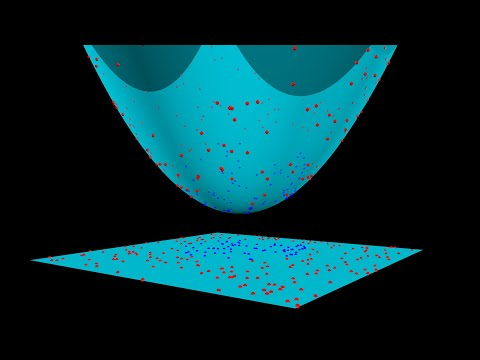

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('3liCbRZPrZA', size=700)

# Teacher: please explain the students what a kernel is, based on this video
# https://www.youtube.com/watch?v=3liCbRZPrZA&ab_channel=udiprod


Let us try it in a toy problem.

In [2]:
#Let's see what the boundary looks like in a toy problem.
%matplotlib inline
%reset -f
import numpy as np
import matplotlib.pyplot as plt
MAXN=10
np.random.seed(2)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1

from sklearn import svm
from sklearn import metrics

In [3]:
delta = 0.05
xx = np.arange(-5.0, 15.0, delta)
yy = np.arange(-5.0, 15.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.c_[Xf[:,np.newaxis],Yf[:,np.newaxis]];

def SVC_gamma(gamma, C):
    clf = svm.SVC(kernel = 'rbf', gamma = gamma, C = C)
    clf.fit(X,y.ravel())
    Z=clf.decision_function(data)
    Z.shape=sz
    plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
    plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
    plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
    plt.contour(XX,YY,Z,[0])
    fig = plt.gcf()
    fig.set_size_inches(9,9)

#from IPython.html.widgets import interact
from ipywidgets import interact 
interact(SVC_gamma, gamma=(0.011,5.,0.01), C = (0.01,2))

interactive(children=(FloatSlider(value=2.5010000000000003, description='gamma', max=5.0, min=0.011, step=0.01…

<function __main__.SVC_gamma(gamma, C)>

### Application to customer churn prediction

Let us apply the RBF kernel SVM to the customer churn prediction. Usually, discriminant classifiers are not affine invariant and we have to consider some feature normalization process. For the sake of fairness, we will use the same standarization method.

In [4]:
import pandas as pd

## Load the data
churn_df = pd.read_csv('churn.csv')
col_names = churn_df.columns.tolist()

# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

# We don't need these columns
to_drop = ['State','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1) #X

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Pull out features for future use
features = churn_feat_space.columns

X = churn_feat_space.values.astype(float)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 3333 observations and 18 features
Unique target labels: [0 1]


In [5]:
#NO SNOOPING
import numpy as np
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics


kf=model_selection.KFold(n_splits=5,  shuffle=False)
kf.get_n_splits(X)
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #Standard parameters
    clf = svm.SVC(kernel='rbf', gamma = 0.051, C = 1)
    clf.fit(X_train,y_train.ravel())
    X_test = scaler.transform(X_test)
    yhat[test_index] = clf.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

Mean accuracy: 0.9186888537713125


/var/folders/dk/ht9wngxs4r51l9tbk0_y94000000gp/T/ipykernel_46915/1347475485.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, size=20)
/var/folders/dk/ht9wngxs4r51l9tbk0_y94000000gp/T/ipykernel_46915/1347475485.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels, size=20)


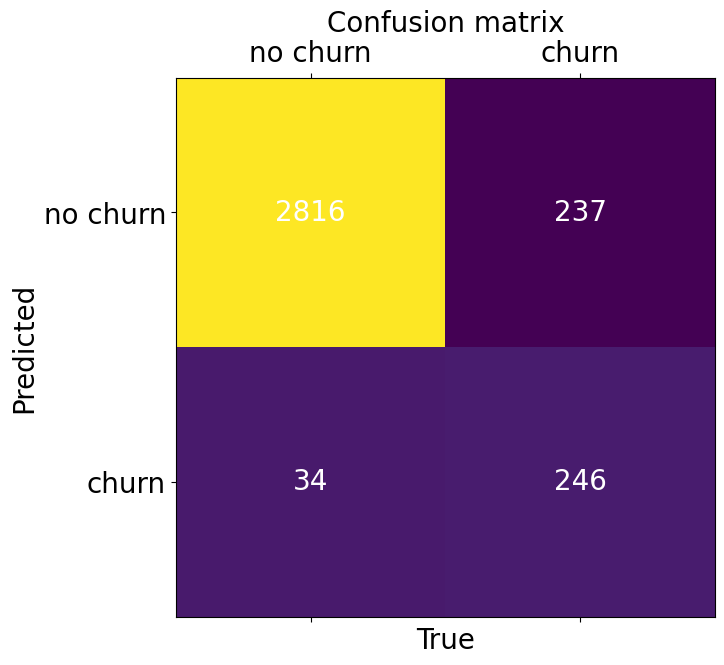

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2850
           1       0.88      0.51      0.64       483

    accuracy                           0.92      3333
   macro avg       0.90      0.75      0.80      3333
weighted avg       0.92      0.92      0.91      3333



In [6]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

Let us cross-validate the parameters and check if we can do better.

In [7]:
#from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
parameters = {'C':[ 2,4,8],'gamma':[0.02, 0.05, 0.1], 'class_weight':[{0:0.5},{0:1},{0:2}]}

kf=model_selection.KFold( n_splits=5, shuffle=False)
kf.get_n_splits(X)
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #Standard parameters
    clf = svm.SVC(kernel='rbf', class_weight={0:1,1:10})
    # We can change the scoring "average_precision", "recall", "f1"
    clf = model_selection.GridSearchCV(clf, parameters, scoring='average_precision')
    clf.fit(X_train,y_train.ravel())
    X_test = scaler.transform(X_test)
    yhat[test_index] = clf.predict(X_test)
    #recall, f1, precision
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    print (str(clf.best_params_))
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

{'C': 2, 'class_weight': {0: 2}, 'gamma': 0.05}
{'C': 4, 'class_weight': {0: 0.5}, 'gamma': 0.05}
{'C': 2, 'class_weight': {0: 2}, 'gamma': 0.05}
{'C': 2, 'class_weight': {0: 2}, 'gamma': 0.05}
{'C': 2, 'class_weight': {0: 2}, 'gamma': 0.05}
Mean accuracy: 0.9180896038467253


/var/folders/dk/ht9wngxs4r51l9tbk0_y94000000gp/T/ipykernel_46915/1347475485.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, size=20)
/var/folders/dk/ht9wngxs4r51l9tbk0_y94000000gp/T/ipykernel_46915/1347475485.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels, size=20)


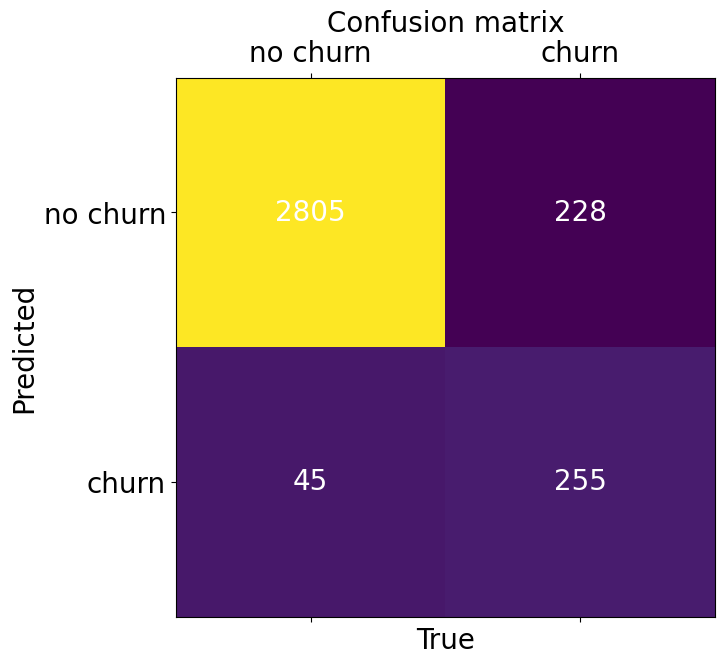

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2850
           1       0.85      0.53      0.65       483

    accuracy                           0.92      3333
   macro avg       0.89      0.76      0.80      3333
weighted avg       0.91      0.92      0.91      3333



In [8]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

**QUESTION:** We are dealing with an unbalanced problem. Lets understand what we could even do to deal with it.
(Imbalanced Dataset slides)
</div>